In [30]:
!pip install albumentations

# Importing required libraries

In [31]:
import os
import cv2
import time
import pandas as pd
from glob import glob
from tqdm import tqdm
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchvision.utils import make_grid

from PIL import Image



# Data Preprocessing 

In [32]:
data_dir = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/'
data_dir = glob(f'{data_dir}/*/*[0-9].tif')

# Read CSV Files Of Data 

In [33]:
csv_path = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

missing_values_count = df.isnull().sum()
missing_values_count

Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64

# Missing Values Handeling 

In [ ]:
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

# Function To Get Data 

In [35]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    
    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments
    
    return [patient_id, path, f'{path_no_ext}_mask{ext}']

# Store the data into a dataframe

In [36]:
PathDF = pd.DataFrame((get_file_row(filename) for filename in data_dir), columns=['Patient', 'image', 'mask'])
PathDF.head()

,Patient,image,mask
0,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
1,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
2,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
4,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...


# Dataset Class  

In [37]:
class MRI_Dataset(Dataset):
    def __init__(self, df, transform=None):
        super(MRI_Dataset, self).__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        img = transforms.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [38]:
df = pd.merge(df, PathDF, on="Patient")  

# Split data into train, valid, and test

In [39]:
train_df, rest = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(rest, test_size=0.3, random_state=42)

print(f"Train: {train_df.shape[0]} | Validation: {valid_df.shape[0]} | Test: {test_df.shape[0]}")

Train: 2750 | Validation: 354 | Test: 825


# Data transformation and loaders

In [40]:
transform = albumentations.Compose([
    albumentations.ChannelDropout(p=0.3),
    albumentations.RandomBrightnessContrast(p=0.3),
    albumentations.ColorJitter(p=0.3),
])

train_dataset = MRI_Dataset(train_df, transform)
valid_dataset = MRI_Dataset(valid_df)
test_dataset = MRI_Dataset(test_df)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

# Data Visualization 

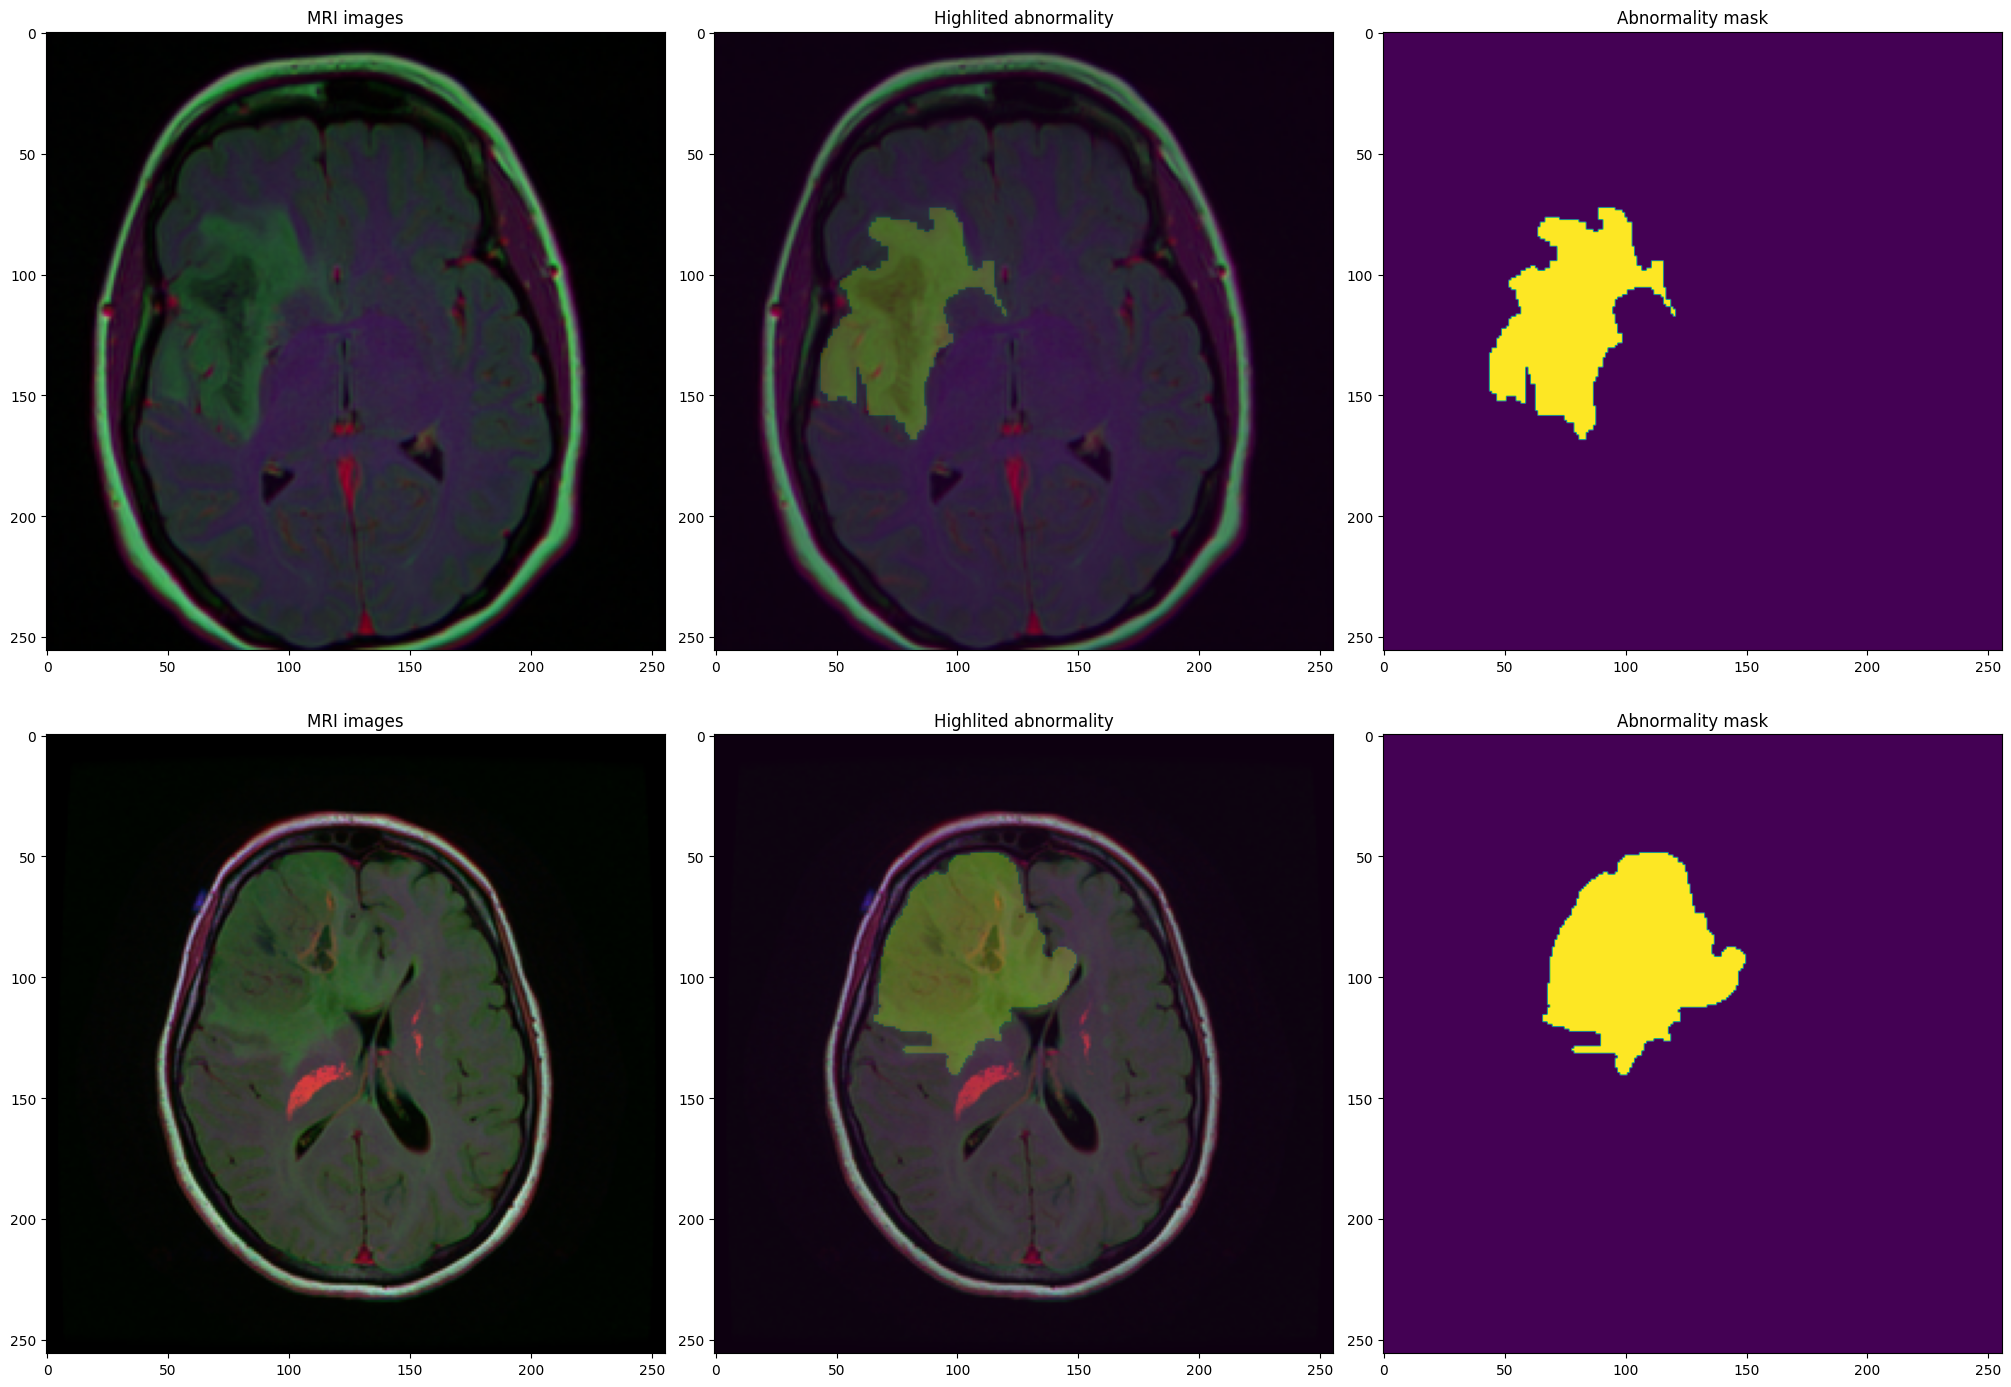

In [41]:
%matplotlib inline
n_examples = 2

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break

# Creating the U-Net architecture

# building the convolutional block

In [42]:
class double_convolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_convolution, self).__init__()
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
        return x

In [43]:
class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x):
        x = self.conv(x)
        return x

# building the encoder 

In [44]:
class downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(downsample_block, self).__init__()
        self.Downconv = nn.Sequential( 
            nn.MaxPool2d(2,2),
            double_convolution(in_channels, out_channels)
         )
    def forward(self, x):
        x = self.Downconv(x)
        return x

# building the decoder 

In [45]:
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [46]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

# Building U-NET Model 

In [47]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64)
        self.down1 = downsample_block(64, 128)
        self.down2 = downsample_block(128, 256)
        self.down3 = downsample_block(256, 512)
        self.down4 = downsample_block(512, 512)
        self.up1 = upsample_block(1024, 256)
        self.up2 = upsample_block(512, 128)
        self.up3 = upsample_block(256, 64)
        self.up4 = upsample_block(128, 64)
        self.outc = OutConv(64, num_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [48]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
model.to(device);

In [49]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 25

In [50]:
def segmentation_accuracy(preds, targets, threshold=0.5): 
    # Apply sigmoid and threshold to get binary predictions
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    acc = correct.sum() / correct.numel()
    return acc   

# Training Loop 

In [51]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        running_loss = 0
        running_acc = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            
            loss = loss_fn(predictions, mask)
            acc = segmentation_accuracy(predictions, mask)
            
            running_loss += loss.item() * img.size(0)
            running_acc += acc.item() * img.size(0)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        running_valid_loss = 0
        running_valid_acc = 0
        with torch.no_grad():
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                
                loss = loss_fn(predictions, mask)
                acc = segmentation_accuracy(predictions, mask)

                running_valid_loss += loss.item() * img.size(0)
                running_valid_acc += acc.item() * img.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        train_acc = running_acc / len(train_loader.dataset)
        val_acc = running_valid_acc / len(valid_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch: {epoch}/{epochs} | '
              f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
    
    model.eval()
    return history


# Model Training 

In [52]:
history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn)

100%|██████████| 172/172 [01:57<00:00,  1.47it/s]


Epoch: 1/25 | Train Loss: 0.1592, Acc: 0.0101 | Val Loss: 0.0464, Acc: 0.0093


100%|██████████| 172/172 [01:55<00:00,  1.49it/s]


Epoch: 2/25 | Train Loss: 0.0368, Acc: 0.0101 | Val Loss: 0.0232, Acc: 0.0093


100%|██████████| 172/172 [01:57<00:00,  1.47it/s]


Epoch: 3/25 | Train Loss: 0.0244, Acc: 0.0101 | Val Loss: 0.0195, Acc: 0.0093


100%|██████████| 172/172 [01:55<00:00,  1.49it/s]


Epoch: 4/25 | Train Loss: 0.0211, Acc: 0.0101 | Val Loss: 0.0150, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 5/25 | Train Loss: 0.0184, Acc: 0.0101 | Val Loss: 0.0139, Acc: 0.0093


100%|██████████| 172/172 [01:57<00:00,  1.47it/s]


Epoch: 6/25 | Train Loss: 0.0171, Acc: 0.0101 | Val Loss: 0.0181, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 7/25 | Train Loss: 0.0160, Acc: 0.0101 | Val Loss: 0.0126, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 8/25 | Train Loss: 0.0155, Acc: 0.0101 | Val Loss: 0.0106, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.47it/s]


Epoch: 9/25 | Train Loss: 0.0142, Acc: 0.0101 | Val Loss: 0.0105, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 10/25 | Train Loss: 0.0133, Acc: 0.0101 | Val Loss: 0.0091, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.47it/s]


Epoch: 11/25 | Train Loss: 0.0121, Acc: 0.0101 | Val Loss: 0.0186, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 12/25 | Train Loss: 0.0120, Acc: 0.0101 | Val Loss: 0.0093, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 13/25 | Train Loss: 0.0114, Acc: 0.0101 | Val Loss: 0.0086, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 14/25 | Train Loss: 0.0103, Acc: 0.0101 | Val Loss: 0.0084, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.47it/s]


Epoch: 15/25 | Train Loss: 0.0104, Acc: 0.0101 | Val Loss: 0.0088, Acc: 0.0093


100%|██████████| 172/172 [01:57<00:00,  1.47it/s]


Epoch: 16/25 | Train Loss: 0.0097, Acc: 0.0101 | Val Loss: 0.0080, Acc: 0.0093


100%|██████████| 172/172 [01:57<00:00,  1.47it/s]


Epoch: 17/25 | Train Loss: 0.0081, Acc: 0.0101 | Val Loss: 0.0076, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.47it/s]


Epoch: 18/25 | Train Loss: 0.0080, Acc: 0.0101 | Val Loss: 0.0085, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.47it/s]


Epoch: 19/25 | Train Loss: 0.0077, Acc: 0.0101 | Val Loss: 0.0072, Acc: 0.0093


100%|██████████| 172/172 [01:57<00:00,  1.47it/s]


Epoch: 20/25 | Train Loss: 0.0071, Acc: 0.0101 | Val Loss: 0.0076, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 21/25 | Train Loss: 0.0071, Acc: 0.0101 | Val Loss: 0.0071, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.47it/s]


Epoch: 22/25 | Train Loss: 0.0070, Acc: 0.0102 | Val Loss: 0.0066, Acc: 0.0093


100%|██████████| 172/172 [01:57<00:00,  1.46it/s]


Epoch: 23/25 | Train Loss: 0.0073, Acc: 0.0102 | Val Loss: 0.0061, Acc: 0.0093


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 24/25 | Train Loss: 0.0065, Acc: 0.0102 | Val Loss: 0.0058, Acc: 0.0093


100%|██████████| 172/172 [01:57<00:00,  1.47it/s]


Epoch: 25/25 | Train Loss: 0.0065, Acc: 0.0102 | Val Loss: 0.0059, Acc: 0.0093


# Plot Results 

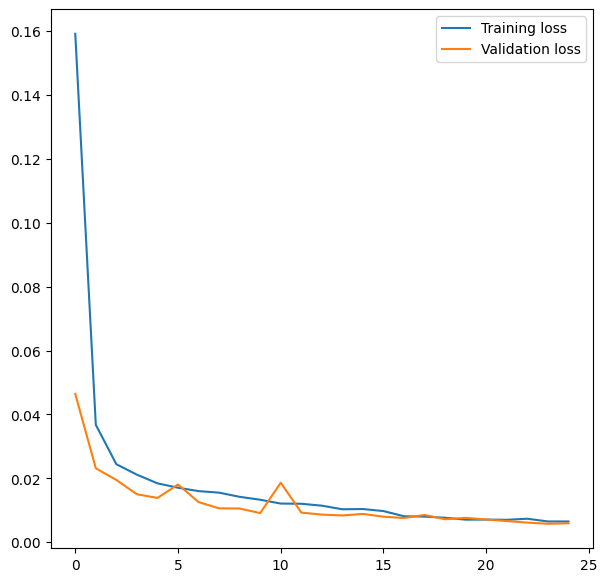

In [56]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# results 

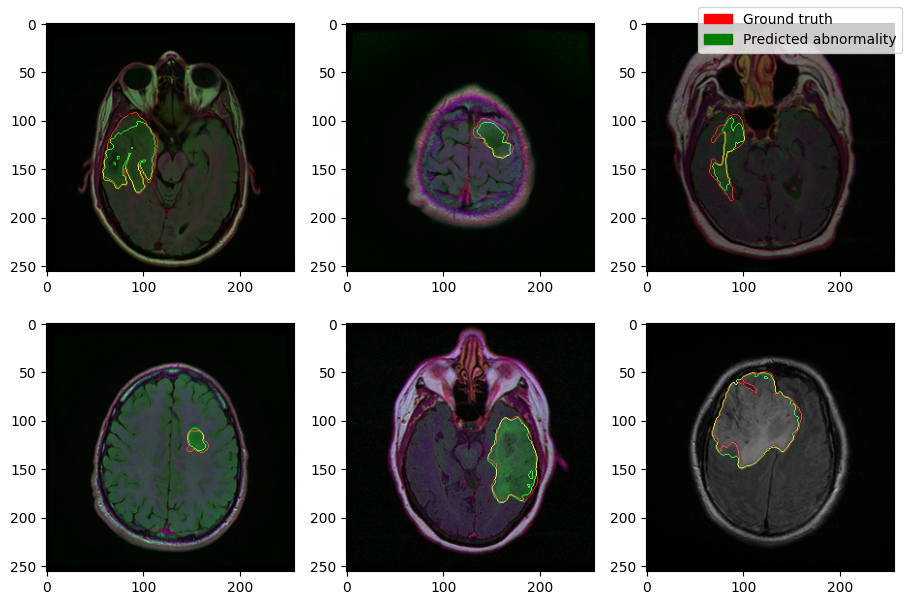

In [60]:
%matplotlib inline

width = 3
columns = 2
n_examples = 6

fig, axs = plt.subplots(columns, width, figsize=(3*width , 3*columns), constrained_layout=True)
red_patch = mpatches.Patch(color='red', label='The red data')
fig.legend(loc='upper right',handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')])
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0]
        if not mask.byte().any():
            continue
        image = image.to(device)
        prediction = model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        prediction_edges = prediction - binary_dilation(prediction)
        ground_truth = mask - binary_dilation(mask)
        image[0, 0, ground_truth.bool()] = 1
        image[0, 1, prediction_edges.bool()] = 1
        
        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        if n_examples == i + 1:
            break
        i += 1